In [4]:
import torch
import torchvision
import torch.optim as optim
from torchvision.transforms import transforms
from torch import nn

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os
import pandas as pd

In [2]:
LR = 1e-4
BATCH_SIZE = 32
EPOCHS = 120

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Définir les transformations à appliquer aux images
# moyenne des proportions des images: 1.28 (w / h)
transform = transforms.Compose(
    [transforms.Resize((220, 172)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))
     ])

# Charger les données d'entrainement
trainset = torchvision.datasets.ImageFolder(root='./data/train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Charger les données de test
testset = torchvision.datasets.ImageFolder(root='./data/test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Définir les classes
classes = ('n01443537', 'n01484850', 'n01537544', 'n01614925', 'n02114367', 'n02133161')

In [5]:
class CNN(nn.Module):
    """
    Sous classe de nn.Module, permettant de définir notre modèle de réseau de neurones
    Ici, il est composé de 3 couches convolutionnelles et 2 couches linéaires
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(4, 4), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(4, 4), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv_3 = nn.Conv2d(64, 64, kernel_size=(8, 8), stride=1, padding=1)
        self.act_3 = nn.ReLU()
        self.pool_3 = nn.MaxPool2d(kernel_size=(4, 4))

        # Utile pour empêcher l'overfitting
        self.drop_3 = nn.Dropout(.3)
 
        # passage d'une matrice à un vecteur
        self.flat = nn.Flatten()
 
        self.fc4 = nn.Linear(6912, 152)
        self.act4 = nn.ReLU()

        self.fc5 = nn.Linear(152, 6)
        self.act5 = nn.ReLU()
 
    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.pool1(x)
        
        x = self.act2(self.conv2(x))
        x = self.pool2(x)

        x = self.act_3(self.conv_3(x))
        x = self.pool_3(x)
        x = self.drop_3(x)

        x = self.flat(x)

        x = self.act4(self.fc4(x))
        
        x = self.act5(self.fc5(x))
        return x
 

In [5]:
torch.manual_seed(0)
model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

In [6]:
def check_accuracy(model, train=None, test=None, epoch=-1, s=False):
    # fonction permettant de calculer la précision du modèle
    model.eval()
    ret = {"train": 0, "test": 0}

    with torch.no_grad():
        for loader, name in zip([train, test], ('train', 'test')):
            num_correct = 0
            num_samples = 0
            if loader is None:
                ret[name] = None
                continue
            for x, y in loader:
                x = x.to(device=device)
                y = y.to(device=device)

                scores = model(x)
                _, predictions = scores.max(1)
                num_correct += (predictions == y).sum()
                num_samples += predictions.size(0)
            if not s:
                print(f'{name} accuracy: {float(num_correct)/float(num_samples)*100:.2f}% at epoch {epoch + 1}')
            ret[name] = float(num_correct)/float(num_samples)*100

    model.train()
    return ret

In [ ]:
# Entrainement du modèle
accuracy = []
losses = []
running_loss = 0.0

for epoch in range(EPOCHS):
    for i, (inputs, labels) in enumerate(tqdm(trainloader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        y_pred = model(inputs).to(device)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    losses.append(running_loss/(i+1))
    running_loss = 0.0
    accuracy.append(check_accuracy(model, trainloader, testloader, epoch))

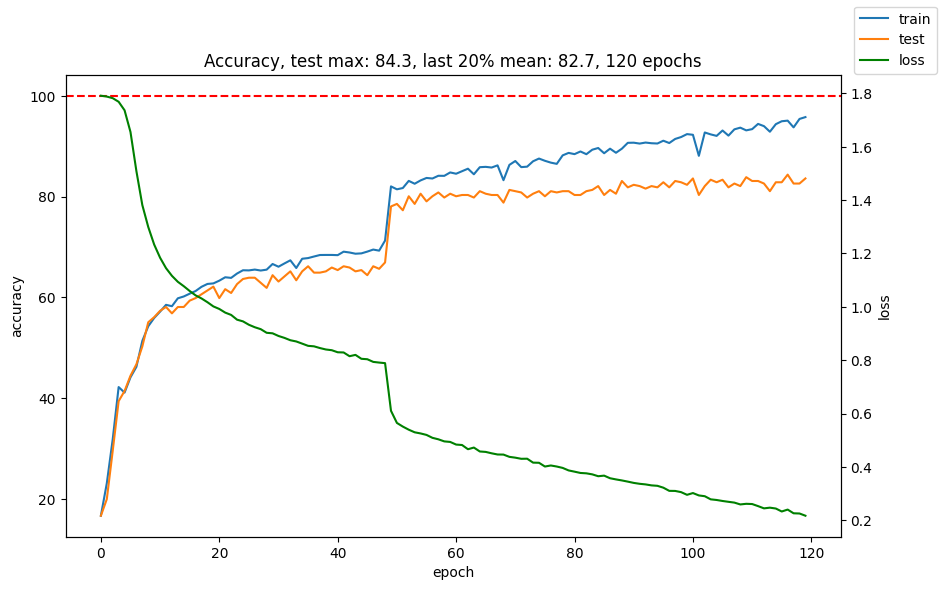

In [10]:
# Affichage d'un graphe montrant l'évolution de la précision et de la loss du modèle
a_test = [x['test'] for x in accuracy]
a_train = [x['train'] for x in accuracy]
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
ax.axhline(100, color='r', linestyle='--')
ax.plot(a_train, label='train')
ax.plot(a_test, label='test')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax1 = ax.twinx()
ax1.set_ylabel('loss')
ax1.plot(losses, color='g', label='loss')
ax.title.set_text(f"Accuracy, test max: {max(a_test):.1f}, last 20% mean: {np.mean(a_test[-len(a_test)//5:]):.1f}, {EPOCHS} epochs")
fig.legend()

plt.show()

In [9]:
# Sauvegarde du modèle pour pouvoir le réutiliser plus tard
torch.save(model.state_dict(), f'./output/model_test-{a_test[-1]:.2f}_train-{a_train[-1]:.2f}.pth')
print(f"model saved as model_test-{a_test[-1]:.2f}_train-{a_train[-1]:.2f}.pth")

model saved as model_test-83.59_train-95.76.pth


# Test du modèle sur les images du dataset de test

In [6]:
import torch
import pandas as pd

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device=device)
state = torch.load('./output/model_test-83.59_train-95.76.pth', map_location=device)
model.load_state_dict(state)


<All keys matched successfully>

In [13]:
transform = transforms.Compose(
    [transforms.Resize((220, 172)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))
     ])

testset = torchvision.datasets.ImageFolder(root='./data/test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)
classes = ('n01443537', 'n01484850', 'n01537544', 'n01614925', 'n02114367', 'n02133161')

In [14]:
test = {"nom_image": [], "reconnue": [], "prediction": []}
n = 0
model.eval()
with torch.no_grad():
    for images, labels in iter(testloader):
        images = images.to(device)
        labels = labels.to(device)
        y_pred = model(images)
        _, predictions = y_pred.max(1)
        for i, (image, label) in enumerate(zip(images, labels)):
            test["nom_image"].append(os.path.basename(testset.imgs[n + i][0]).split(".")[0])
            test["reconnue"].append(int(predictions[i] == label))
            test["prediction"].append(classes[predictions[i]])
        n += i+1

model.train()

print(f'{test["reconnue"].count(0)} images non reconnues sur {len(testset)} images: {100*test["reconnue"].count(0)/len(testset):.2f} %')

65 images non reconnues sur 396 images: 16.41 %


In [15]:
_ = pd.DataFrame(test).to_csv("./output/imgs_reconnues.csv", index=False)

# Reconstituion du fichier pour la suite du programme

In [16]:
rec = pd.read_csv("./output/imgs_reconnues.csv")
df = pd.read_csv("./animals_id_name_subClass_sub2Class.csv")

ids = []
classe = []

for i in rec.nom_image:
    ids.append(i.split("_")[1])
    classe.append(i.split("_")[0])

rec["nom_image"] = ids
rec["classe"] = classe

res = pd.merge(rec, df, left_on="classe", right_on="id", how="left")

res.nom_image = res.id + "_" + res.nom_image
res.classe = res.animalLabel
res = res[['nom_image', 'classe', 'subclassLabel', 'reconnue']]
res.head()

,nom_image,classe,subclassLabel,reconnue
0,n01443537_8662,goldfish,0,1
1,n01443537_8693,goldfish,0,1
2,n01443537_8719,goldfish,0,0
3,n01443537_875,goldfish,0,1
4,n01443537_8787,goldfish,0,1


In [22]:
res.to_csv("./reconnues.csv", index=0)